### Students
- Student 1: <span style="color:green">253885 - Luca Franceschi</span>

# Lab 4: Stereo Matching and Shape from Silhouette

This lab session is divided in two parts. In the first one, you will compute a disparity map from a pair of images.  A disparity map is an image that stores the inverse of the distance to the camera center of the points
seen at every pixel, i.e. the depth.  This will enable us, for example in case our cameras are calibrated, to display a dense cloud of points representing the scene.

To compute the disparity map with a local method, we will have to compute correspondences for every pixel in the reference image.  These are many more correspondences than the ones given by SIFT/SURF/ORB.  For every pixel in the first image, we will travel its corresponding epipolar line in the second image looking for its correspondence. Since the pair of images are stereo-rectified (parallel views) the epipolar lines are horizontal and the coordinates of the corresponding points differ just by a horizontal displacement, the disparity.  By comparing the information around a neighborhood of the pixels on both images we will decide whether the pixels do correspond to each other.

In the second part, you will compute a 3D reconstruction of an object given some binary images corresponding to different points of view. These binary images, called the silhouettes, contain a segmentation of the object of interest that we want to reconstruct.

In particular, the goal of this lab session is to learn the following concepts:

- How to compute disparity/depth maps from pairs of images.
- Compare different cost functions and window sizes.
- How to aggregate costs through bilateral weights.
- How to extract a Visual Hull from a set of different views.

You will have to answer the questions and complete the provided code when necessary as required. **You must deliver the completed (and executed) ipynb file, including the answers to the questions (please make clear visually what it is answer, either preceding it by ANSWER and/or changing its color).**

In [1]:
import math

import cv2
import ipyvolume as ipv
import matplotlib
import numpy as np
import seaborn_image as isns
from ipywidgets import IntSlider, interact
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from tqdm.notebook import tnrange, tqdm

## 1. Stereo matching

First we will work with a pair of stereo-recified images from the Middlebury stereo dataset: http://vision.middlebury.edu/stereo/. The ground truth disparity is available and it will be useful to validate the code to be completed and it will allow us to measure errors as well.

The incomplete function `stereo_computation` is provided; you have to complete it with the SSD cost, the NCC similarity measure and the bilateral weights.

**Q1.** Complete the `stereo_computation` function with the computation of the SSD cost.


In [ ]:
def stereo_computation(
    color_ref_img, color_target_img, min_disparity, max_disparity, win_size, bilateral_weights=False, method="ssd"
):
    """
    -left image
    -right image
    -minimum disparity
    -maximum disparity
    -window size
    -bilateral_weights
    -matching cost
    """

    # conversion to float images to make calculations
    color_ref_img = color_ref_img.astype(np.float32)
    color_target_img = color_target_img.astype(np.float32)

    # complete ...
    height, width, _ = color_ref_img.shape
    estimated_disparity_map_idxs = np.zeros(shape=(height, width))
    matching_cost = np.zeros((max_disparity - min_disparity))
    half_win_size = win_size // 2
    
    gamma_col = 12
    gamma_pos = half_win_size
    
    # NOTE: initialize here, always three channels even though not really used in ssd
    weights = np.zeros((win_size, win_size, 1)) 
        
    # iterate over the image
    description = f"Stereo computation: {method.upper()} \
with {win_size}x{win_size} window \
and {'bilateral' if bilateral_weights else 'uniform'} weights"
    
    for i in tnrange(half_win_size, height - half_win_size, desc=description):
        for j in range(half_win_size, width - half_win_size):
            
            # TODO: Define the window for the reference image
            # NOTE: IT IS (HEIGHT, WIDTH) !!! too used to (width, height)
            # NOTE: window centered at position (i, j) and size (height, width)
            window_ref_img = color_ref_img[i - half_win_size : i + half_win_size + 1,
                                           j - half_win_size : j + half_win_size + 1]

            # TODO: Define the disparity range
            disparity_range = range(min_disparity, max_disparity)

            if bilateral_weights:
                # TODO: ANSWER Q7 - Code for bilateral weights.
                delta_c = np.sum(np.abs(color_ref_img[i, j] - window_ref_img), axis=2) / 3
                
                # inspo from: https://stackoverflow.com/a/32208788
                q = np.mgrid[i - half_win_size : i + half_win_size + 1, j - half_win_size : j + half_win_size + 1].reshape(-1, win_size, win_size).T
                p = np.full((win_size, win_size, 2), np.array((i, j)))

                delta_g = np.sqrt(np.sum((p - q)**2, axis=2))
                
                weights[:, :, 0] = np.exp(-delta_c / gamma_col) * np.exp(-delta_g / gamma_pos)

            else:
                # TODO: Code for uniform weights.
                weights[:, :, :] = 1 / (win_size * win_size * 3)

            for d in disparity_range:
                # TODO: Ensure that the disparity does not go out of bounds
                new_center = j + d
                if (new_center + half_win_size + 1 > width or
                    new_center - half_win_size < 0): # NOTE: check that left boundary is correct
                    continue

                # TODO: Define the window for the second image
                window_target_img = color_target_img[i - half_win_size : i + half_win_size + 1,
                            new_center - half_win_size : new_center + half_win_size + 1]

                if method == "ssd":
                    # TODO: ANSWER Q1
                    matching_cost[d - min_disparity] = np.sum(weights * (window_ref_img - window_target_img)**2)

                elif method == "ncc":
                    # TODO: ANSWER Q5
                    sum_weighed_ref = np.sum(weights * window_ref_img)
                    sum_weighed_target = np.sum(weights * window_target_img)
                    std1 = np.sqrt(np.sum(weights * (window_ref_img - sum_weighed_ref)**2))
                    std2 = np.sqrt(np.sum(weights * (window_target_img - sum_weighed_target)**2))

                    matching_cost[d - min_disparity] = -np.sum(weights * (window_ref_img - sum_weighed_ref) * (window_target_img - sum_weighed_target)) / (std1 * std2)

                else:
                    raise (NameError)
            
            # TODO: Update disparity map
            estimated_disparity_map_idxs[i, j] = np.argmin(matching_cost) # NOTE: indexes, not estimation !

    return estimated_disparity_map_idxs

**Q2.** Execute cell code given after the `stereo_computation` function. This code estimates the disparity between a pair of stereo rectified images.

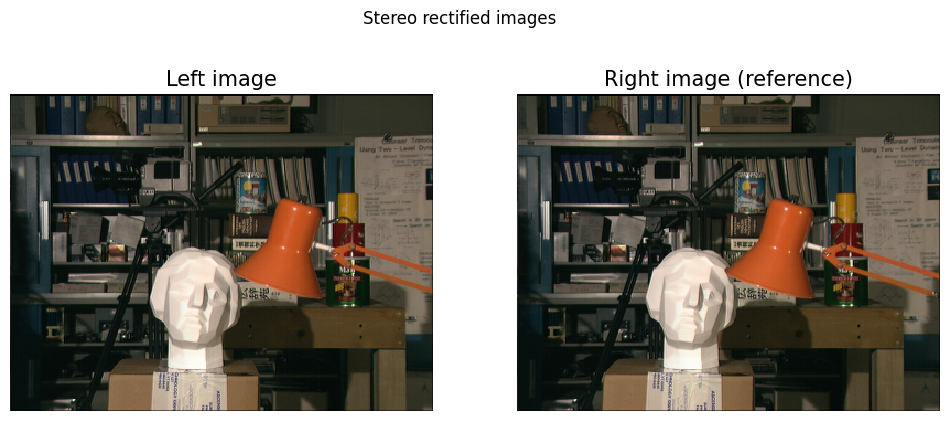

In [3]:
# Data images (rectified images)
img1 = cv2.imread("./data1/scene1.row3.col3.ppm")
img2 = cv2.imread("./data1/scene1.row3.col2.ppm")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 5))
plt.suptitle("Stereo rectified images")
for i, (image, title) in enumerate(zip([img2, img1], ["Left image", "Right image (reference)"]), start=1):
    plt.subplot(1, 2, i)
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
plt.show()

In [4]:
# Set minimum and maximum disparity
min_disparity = 0
max_disparity = 16

# Set window (patch) size
w_size = 9
ssd_disp = np.zeros(shape=(img1.shape[0], img1.shape[1]))
ssd_disp = stereo_computation(img1, img2, min_disparity, max_disparity, w_size, bilateral_weights=False, method="ssd")

Stereo computation: SSD with 9x9 window and uniform weights:   0%|          | 0/280 [00:00<?, ?it/s]

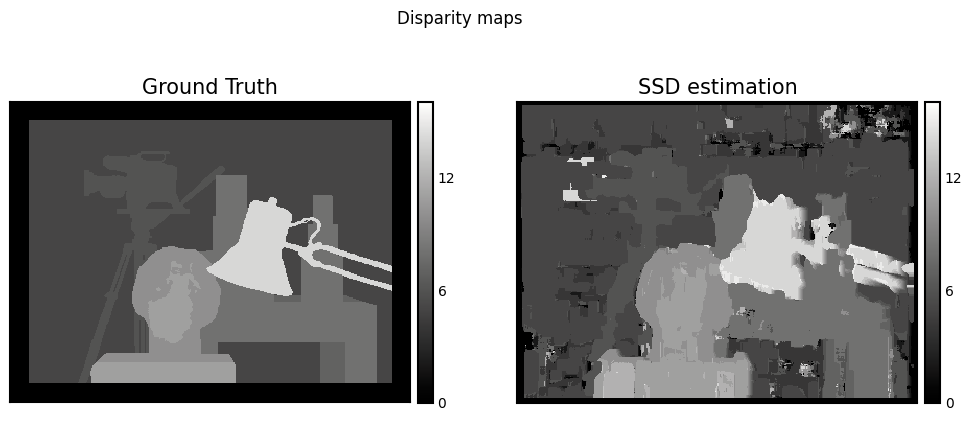

In [5]:
# Disparity ground truth image
img_gt = cv2.imread("./data1/truedisp.row3.col3.pgm", cv2.IMREAD_GRAYSCALE)
img_gt = img_gt / 16.0

# Display the estimated image with respect to the ground truth
plt.figure(figsize=(12, 5))
plt.suptitle("Disparity maps")
for i, (image, title) in enumerate(zip([img_gt, ssd_disp], ["Ground Truth", "SSD estimation"]), start=1):
    ax = plt.subplot(1, 2, i)
    plt.title(title)
    isns.imshow(image, ax=ax, gray=True, vmax=max(np.max(img_gt), max_disparity))
plt.show()

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color:rgba(255, 255, 255, 0);">
  <strong>🎥 Video Question (Q2):</strong>
  <ul>
    <li>What is the relationship between estimation errors and occluded regions? Why?</li>
    <li>Show an example in the plot above.</li>
  </ul>
</div>


**Q3.** Compute the global error between the ground truth and the estimated disparity map. You should apply the MSE.

*Note that we want to compare only the disparity where the ground truth has values different from zero. I.e. we don't want to compare the borders of the disparity maps, where the ground truth has zero values (in black above). Thus, you should apply some kind of masking.


In [6]:
def compute_mse(ground_truth_disp_map, estimated_disp_map):
    # TODO: Compute the mean squared error (MSE) between the estimated disparity map and the ground truth disparity map
    idxs = (ground_truth_disp_map > 0) & (estimated_disp_map > 0)
    
    # # Display the estimated image with respect to the ground truth
    # plt.figure(figsize=(12, 5))
    # plt.suptitle("Disparity maps")
    # for i, (image, title) in enumerate(zip([ground_truth_disp_map, estimated_disp_map], ["Ground Truth", "SSD estimation"]), start=1):
    #     ax = plt.subplot(1, 2, i)
    #     plt.title(title)
    #     isns.imshow(np.where((ground_truth_disp_map > 0) & (estimated_disp_map > 0), image, 0), ax=ax, gray=True, vmax=max(np.max(img_gt), max_disparity))
    # plt.show()
    
    return np.mean((ground_truth_disp_map[idxs] - estimated_disp_map[idxs])**2)


print(f"MSE: {compute_mse(img_gt, ssd_disp):.2f}")

MSE: 3.23



**Q4.** Evaluate the results changing the window size (e.g. $5 \times 5$, $9 \times 9$, $21 \times 21$). Show the results in 3 plots side by side.


In [7]:
# CODE ANSWER Q4
ssd_disp_per_window = {}

# TODO: Compute the disparity map for different window sizes
for w_size in [5, 9, 21]:
    ssd_disp_per_window[f"{w_size}x{w_size}"] = stereo_computation(img1, img2, min_disparity, max_disparity, w_size, bilateral_weights=False, method="ssd")

Stereo computation: SSD with 5x5 window and uniform weights:   0%|          | 0/284 [00:00<?, ?it/s]

Stereo computation: SSD with 9x9 window and uniform weights:   0%|          | 0/280 [00:00<?, ?it/s]

Stereo computation: SSD with 21x21 window and uniform weights:   0%|          | 0/268 [00:00<?, ?it/s]

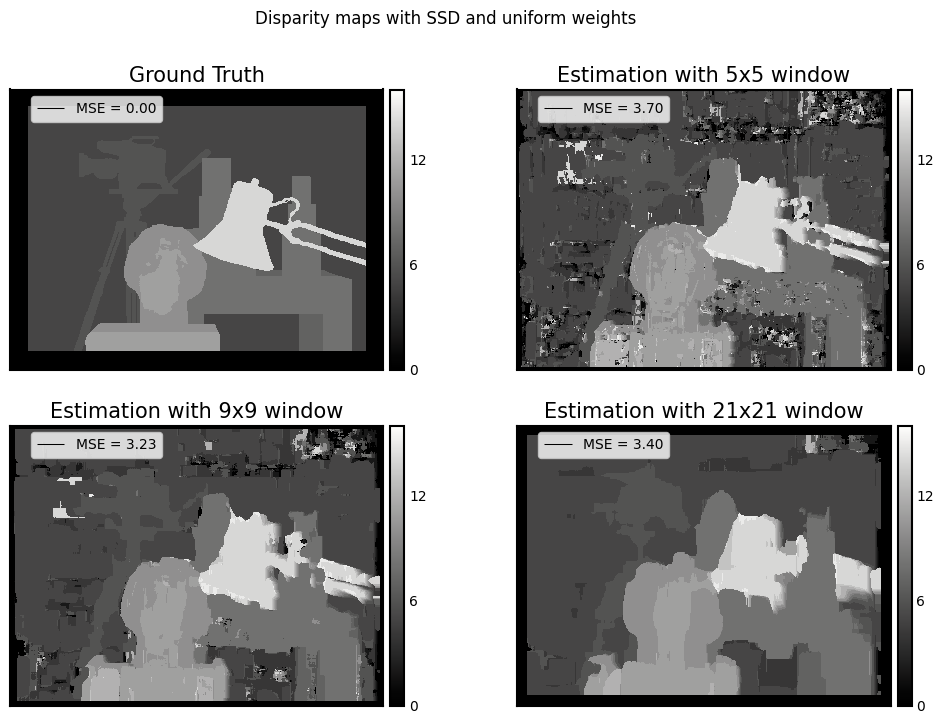

In [8]:
# Display the estimated image with respect to the ground truth
plt.figure(figsize=(12, 8))
plt.suptitle("Disparity maps with SSD and uniform weights")
for i, (image, title) in enumerate(
    zip(
        [img_gt, *ssd_disp_per_window.values()],
        ["Ground Truth", *[f"Estimation with {k} window" for k in ssd_disp_per_window.keys()]],
    ),
    start=1,
):
    ax = plt.subplot(2, 2, i)
    plt.title(title)
    isns.imshow(image, ax=ax, gray=True, vmax=max(np.max(img_gt), max_disparity))
    
    # TODO: Compute the mse
    mse = compute_mse(img_gt, image)

    plt.legend([f"MSE = {mse:.2f}"], loc="upper center", bbox_to_anchor=(-21, 1))
plt.show()

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <strong>🎥 Video Question (Q4):</strong>
  <ul>
    <li>What are the key differences between the disparity maps, and how do they relate to window size?</li>
  </ul>
</div>


**Q5.** Complete the `stereo_computation` function with the computation of the NCC cost (In the first code cell).



**Q6.** Evaluate the results changing the window size (e.g. $5 \times 5$, $9 \times 9$, $21 \times 21$). Show the results in 3 plots side by side.


In [9]:
# CODE ANSWER Q6
ncc_disp_per_window = {}

# TODO: Compute the disparity map for different window sizes
for w_size in [5, 9, 21]:
    ncc_disp_per_window[f"{w_size}x{w_size}"] = stereo_computation(img1, img2, min_disparity, max_disparity, w_size, bilateral_weights=False, method="ncc")

Stereo computation: NCC with 5x5 window and uniform weights:   0%|          | 0/284 [00:00<?, ?it/s]

Stereo computation: NCC with 9x9 window and uniform weights:   0%|          | 0/280 [00:00<?, ?it/s]

Stereo computation: NCC with 21x21 window and uniform weights:   0%|          | 0/268 [00:00<?, ?it/s]

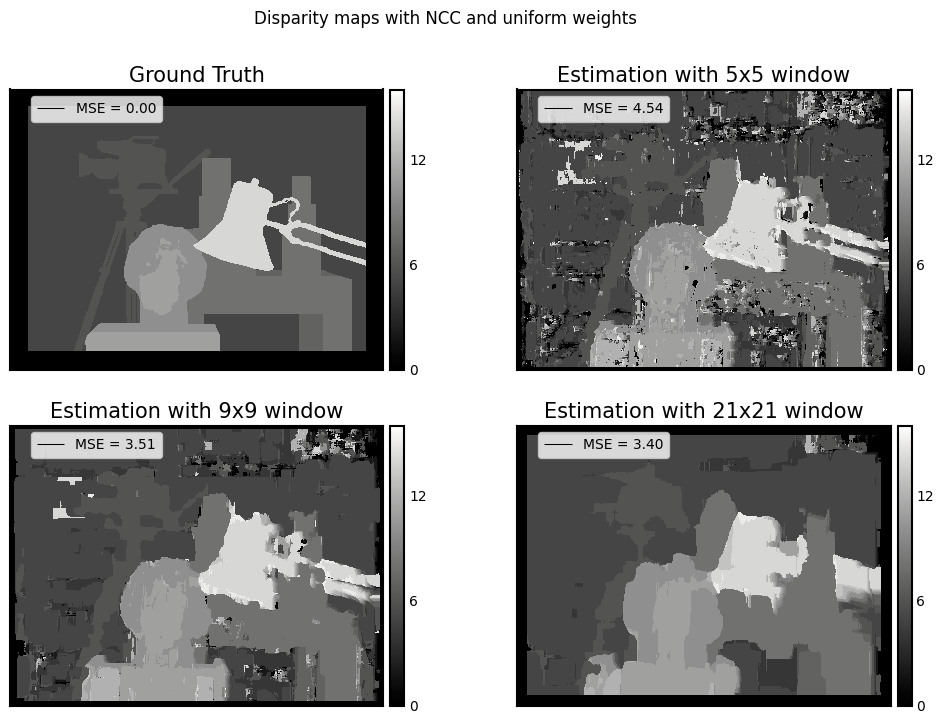

In [10]:
plt.figure(figsize=(12, 8))
plt.suptitle("Disparity maps with NCC and uniform weights")
for i, (image, title) in enumerate(
    zip(
        [img_gt, *ncc_disp_per_window.values()],
        ["Ground Truth", *[f"Estimation with {k} window" for k in ncc_disp_per_window.keys()]],
    ),
    start=1,
):
    ax = plt.subplot(2, 2, i)
    plt.title(title)
    isns.imshow(image, ax=ax, gray=True, vmax=max(np.max(img_gt), max_disparity))
    mse = compute_mse(img_gt, image)
    plt.legend([f"MSE = {mse:.2f}"], loc="upper center", bbox_to_anchor=(-21, 1))
plt.show()

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <strong>🎥 Video Question (Q6):</strong>
  <ul>
    <li>Again, what are the key differences between the disparity maps, and how do they relate to window size?</li>
    <li>Is there any difference compared to the SSD results?</li>
  </ul>
</div>


**Q7.** Complete the `stereo_computation` function from the first code cell with the bilateral weights. Suggested parameters: $\gamma_{col}=12$ and $\gamma_{pos} = win\_size // 2$.


<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <strong>🎥 Video Question (Q7):</strong>
  <ul>
    <li>Briefly explain how bilateral weights work.</li>
  </ul>
</div>


**Q8.** Evaluate bilateral weights changing the window size (e.g. $5 \times 5$, $9 \times 9$, $21 \times 21$) and compare to the previous case that uses uniform weights (SDD cost).

In [11]:
# CODE ANSWER Q8
ssd_bilat_disp_per_window = {}

# TODO: Compute the disparity map for different window sizes
for w_size in [5, 9, 21]:
    ssd_bilat_disp_per_window[f"{w_size}x{w_size}"] = stereo_computation(img1, img2, min_disparity, max_disparity, w_size, bilateral_weights=True, method="ssd")

Stereo computation: SSD with 5x5 window and bilateral weights:   0%|          | 0/284 [00:00<?, ?it/s]

Stereo computation: SSD with 9x9 window and bilateral weights:   0%|          | 0/280 [00:00<?, ?it/s]

Stereo computation: SSD with 21x21 window and bilateral weights:   0%|          | 0/268 [00:00<?, ?it/s]

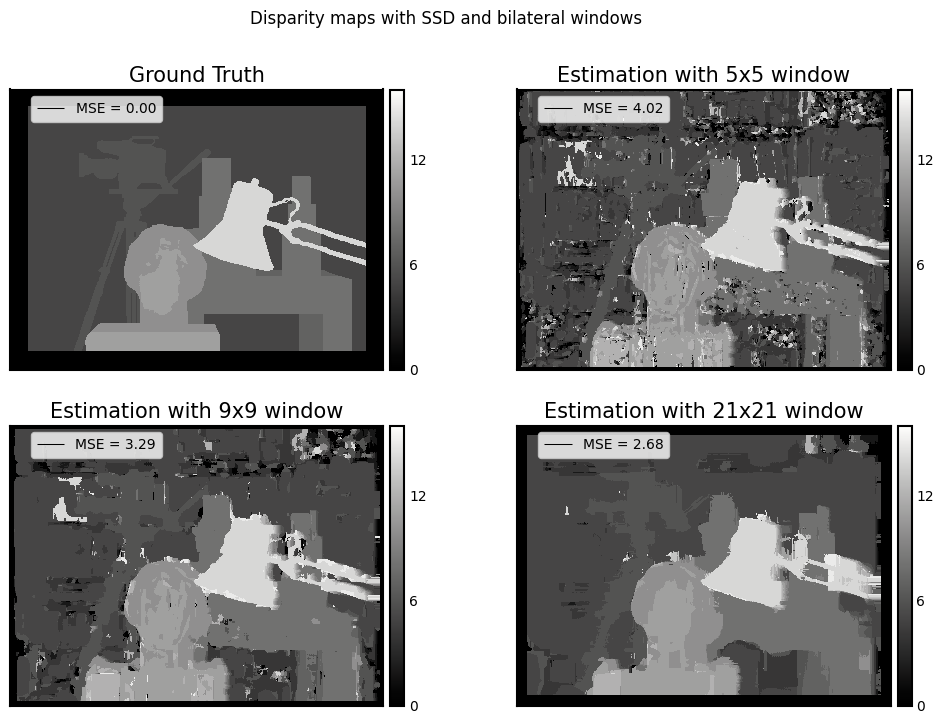

In [12]:
# Display the estimated image with respect to the ground truth
plt.figure(figsize=(12, 8))
plt.suptitle("Disparity maps with SSD and bilateral windows")
for i, (image, title) in enumerate(zip([img_gt, *ssd_bilat_disp_per_window.values()], ["Ground Truth", *[f"Estimation with {k} window" for k in ssd_disp_per_window.keys()]]), start=1):
    ax = plt.subplot(2, 2, i)
    plt.title(title)
    isns.imshow(image, ax=ax, gray=True, vmax=max(np.max(img_gt), max_disparity))
    
    # TODO: Compute the mse
    mse = compute_mse(img_gt, image)

    plt.legend([f"MSE = {mse:.2f}"], loc='upper center', bbox_to_anchor=(-21,1))
plt.show()

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <strong>🎥 Video Question (Q6):</strong>
  <ul>
    <li>Comment the results. Compare them with SSD with uniform weights.</li>
  </ul>
</div>

Once the code is completed and you finish the experiments with the Middlebury image, the next step is to apply the code to our lab 4 images. These images are not rectified, we have rectified them by applying a proper homography to each one of them. The stereo-rectified images are the ones provided in this lab. The lab images are big. To speed up the computations, you can scale-down the images by a factor of 0.25. Once everything is working properly, you can increase the scale in order to get higher resolution results.

**Q9.** Set appropriate values for the disparity limits.

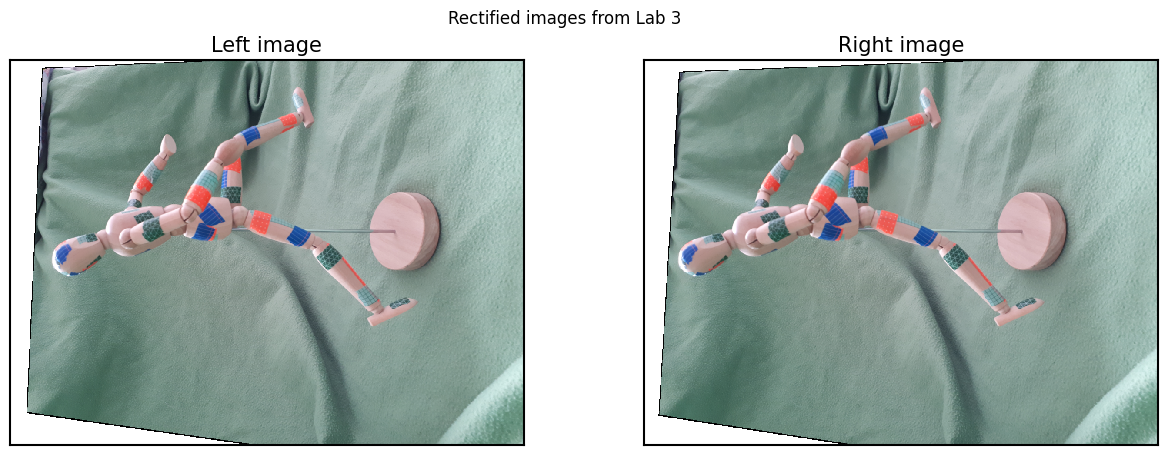

In [13]:
# Data images (rectified images)
img1 = cv2.imread("./data1/rectif0.png")
img2 = cv2.imread("./data1/rectif1.png")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Showing images
plt.figure(figsize=(15, 5))
plt.suptitle("Rectified images from Lab 3")
for i, (image, title) in enumerate(zip([img1, img2], ["Left image", "Right image"]), start=1):
    ax = plt.subplot(1, 2, i)
    plt.title(title)
    isns.imshow(image, ax=ax)

Stereo computation: SSD with 5x5 window and bilateral weights:   0%|          | 0/217 [00:00<?, ?it/s]

Stereo computation: SSD with 9x9 window and bilateral weights:   0%|          | 0/213 [00:00<?, ?it/s]

Stereo computation: SSD with 21x21 window and bilateral weights:   0%|          | 0/201 [00:00<?, ?it/s]

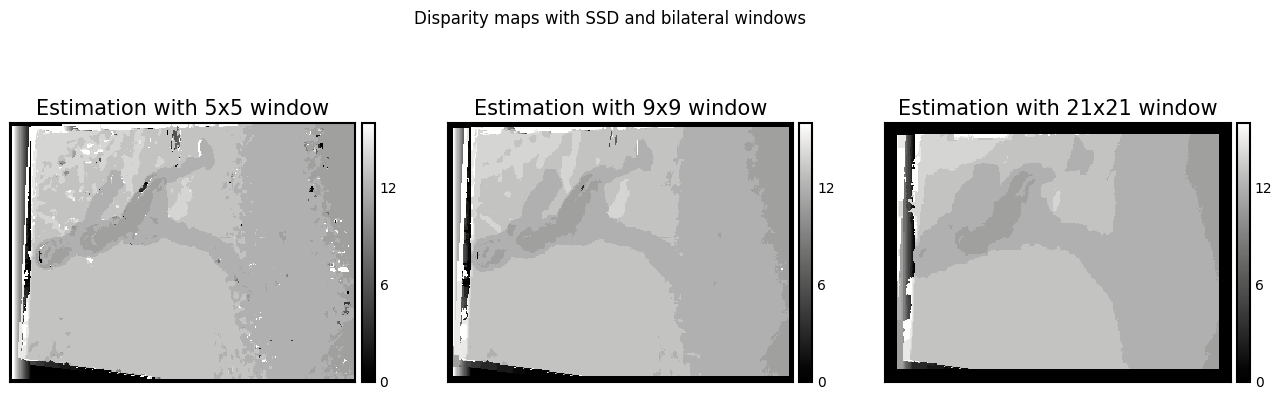

In [14]:
# RESIZE FOR A LIGHTER COMPUTATION
# Calculate the new dimensions
scaling_factor = 0.25
new_width = int(img1.shape[1] * scaling_factor)
new_height = int(img1.shape[0] * scaling_factor)
new_dim = (new_width, new_height)

# Resize the images
resized_img1 = cv2.resize(img1, new_dim, interpolation=cv2.INTER_AREA)
resized_img2 = cv2.resize(img2, new_dim, interpolation=cv2.INTER_AREA)

# TODO: ANSWER Q9 resized
min_disparity = -16
max_disparity = 16

ssd_lab3_resized = {}

# TODO: Compute the disparity map for different window sizes
for w_size in [5, 9, 21]:
    ssd_lab3_resized[f"{w_size}x{w_size}"] = stereo_computation(resized_img1, resized_img2, min_disparity, max_disparity, w_size, bilateral_weights=True, method="ssd")

# Display the estimated disparity maps
plt.figure(figsize=(16, 5))
plt.suptitle("Disparity maps with SSD and bilateral windows")
for i, (window, image) in enumerate(ssd_lab3_resized.items(), start=1):
    ax = plt.subplot(1, 3, i)
    plt.title(f"Estimation with {window} window")
    isns.imshow(image, ax=ax, gray=True, vmax=max_disparity)
plt.show()

Stereo computation: SSD with 21x21 window and bilateral weights:   0%|          | 0/866 [00:00<?, ?it/s]

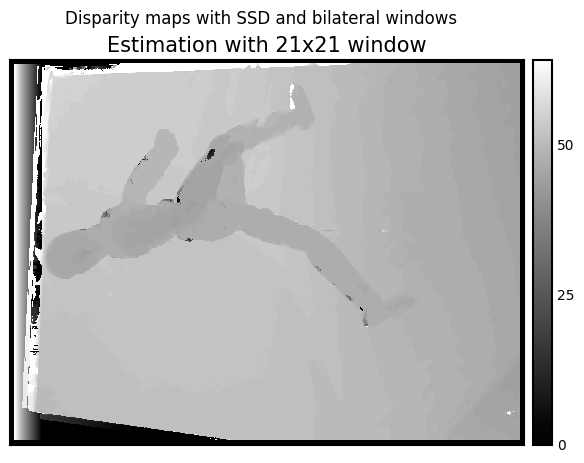

In [61]:
# ANSWER Q9 with original size
# Hint: It will take time to run the code with original size, so pick one window size that you think that will work based on the resized images.
min_disparity = -16*4
max_disparity = 16*4

ssd_lab3 = {}

w_size = 5 * 4 + 1

# TODO: Compute the disparity map for different window sizes
ssd_lab3[f"{w_size}x{w_size}"] = stereo_computation(img1, img2, min_disparity, max_disparity, w_size, bilateral_weights=True, method="ssd")

# Display the estimated disparity maps
plt.figure(figsize=(16, 5))
plt.suptitle("Disparity maps with SSD and bilateral windows")
for i, (window, image) in enumerate(ssd_lab3.items(), start=1):
    ax = plt.subplot(1, 1, i)
    plt.title(f"Estimation with {window} window")
    isns.imshow(image, ax=ax, gray=True, vmax=max_disparity)
plt.show()

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <strong>🎥 Video Question (Q10):</strong>
  <ul>
    <li>Comment the result obtained qualitatively.</li>
    <li>How did you change the disparity limits when using original image sizes?</li>
    <li>Is the disparity well estimated all around the image?</li>
  </ul>
</div>

## 2. Shape from silhouette: visual hull method

The Visual Hull is a 3D reconstruction technique that allows to recover a 3D shape given its silhouettes in different views. A silhouette is a mask that provides a segmentation of the foreground object. The Visual Hull may be obtained as the intersection of the visual cones of the different points of view, which are generated by backprojection of the silhouttes using camera parameters. The advantage of this method is that it is very simple, it is non-iterative and can be easily parallelized. Its main disadvantage is the inability to obtain the exact shape of the object (e.g. cavities in the object cannot be recovered) but it is widely used with multi-view stereo algorithms, either as a first step or in conjunction with the multi-view reconstruction providing additional constraints.
In practice, the visual cones are not estimated, instead, a voxel grid is defined and all the voxels of the grid are projected onto each image ir order to check if the voxel projects inside the object silhouette or not.

In order to visualize the 3D volume we will use the Python library IPyvolume: https://ipyvolume.readthedocs.io/en/latest/ 

You will have to install the library, more information here: https://ipyvolume.readthedocs.io/en/latest/install.html

In our case it worked with the following commands:

- `pip install ipyvolume`
 
- `jupyter nbextension enable --py --sys-prefix ipyvolume` 
 
- `jupyter nbextension enable --py --sys-prefix widgetsnbextension`

Execute the code in the cell below.


In [62]:
# Shape from silhouette - Visual Hull algorithm

# Load images and projection matrices
numCameras = 18
original_images = [cv2.imread("data2/david_{:02d}.jpg".format(i), cv2.IMREAD_GRAYSCALE) for i in range(numCameras)]
P_matrices = [np.loadtxt("data2/david_{:02d}.pa".format(i), delimiter=" ") for i in range(numCameras)]

# Compute silhouettes
silhouetteThreshold = 100
silhouettes = [cv2.threshold(im, silhouetteThreshold, 255, cv2.THRESH_BINARY)[1] for im in original_images]

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <strong>🎥 Video Question (Q11):</strong>
  <ul>
    <li>How are the silhouettes extracted in the provided code?</li>
    <li>Would it work in a general case? Why?</li>
  </ul>
</div>

In [63]:
# Define function to display images and silhouettes
def display_image_with_silhouette(num_image):
    i = num_image
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display original image
    axes[0].imshow(original_images[i], cmap="gray")
    axes[0].set_title(f"Image {i:02d}")
    axes[0].axis("off")

    # Display silhouette
    axes[1].imshow(silhouettes[i], cmap="gray")
    axes[1].set_title(f"Silhouette {i:02d}")
    axes[1].axis("off")

    plt.show()


# Create slider
slider = IntSlider(min=0, max=numCameras - 1, step=1, value=0)

# Display interactive slider and images
display(interact(display_image_with_silhouette, num_image=slider))

interactive(children=(IntSlider(value=0, description='num_image', max=17), Output()), _dom_classes=('widget-in…

<function __main__.display_image_with_silhouette(num_image)>


Execute the following cell code.

In [64]:
# Bounding box of the volume in 3D space.
# This bounding box represents the region where the visual hull reconstruction will take place.
bbox = np.array([[0.2, -0.3, -1.8], [2.2, 1.3, 2.6]])  # [minX minY minZ; maxX maxY maxZ]

# Volume Resolution
# These variables determine the size of the voxel grid used for the visual hull reconstruction. Larger values result in higher resolution but require more computational resources.
volumeX = 40  # 64 # start with a small volume and once code works properly you can increase its size
volumeY = 40  # 64
volumeZ = 80  # 128

# Transformation Matrix (T)
# T is a transformation matrix that maps coordinates from the bounding box space to the image space.
T = np.identity(4)
T[:3, 3] = bbox[0, :]
T = T @ np.diag(
    [(bbox[1, 0] - bbox[0, 0]) / volumeX, (bbox[1, 1] - bbox[0, 1]) / volumeY, (bbox[1, 2] - bbox[0, 2]) / volumeZ, 1]
)
F = np.array(
    [[1, 0, 0, 0], [0, 0, 1, 0], [0, -1, 0, 0], [0, 0, 0, 1]]
)  # flip y and z axes for better display in isosurface
T = F @ T

# Corner Points
# corners represent the eight corner points of the voxel grid in the voxel grid space.
corners = np.array(
    [
        [0, 0, 0, 1],
        [0, 0, volumeZ, 1],
        [0, volumeY, 0, 1],
        [0, volumeY, volumeZ, 1],
        [volumeX, 0, 0, 1],
        [volumeX, 0, volumeZ, 1],
        [volumeX, volumeY, 0, 1],
        [volumeX, volumeY, volumeZ, 1],
    ]
)
corners = corners.T

In [ ]:
# Define function to display images and silhouettes
def display_image_with_silhouette(num_image):
    i = num_image
    
    pcorners = P_matrices[i] @ T @ corners
    pcorners = pcorners[:2] / pcorners[2:]  # From P^2 to R^2

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display original image
    axes[0].imshow(original_images[i], cmap="gray")
    axes[0].set_title(f"Image {i:02d}")
    axes[0].scatter(x=pcorners[0, :], y=pcorners[1, :], c="yellow", s=10)
    axes[0].axis("off")

    # Display silhouette
    axes[1].imshow(silhouettes[i], cmap="gray")
    axes[1].set_title(f"Silhouette {i:02d}")
    axes[1].scatter(x=pcorners[0, :], y=pcorners[1, :], c="yellow", s=10)
    axes[1].axis("off")
    
    plt.show()


# Create slider
slider = IntSlider(min=0, max=numCameras - 1, step=1, value=0)

# Display interactive slider and images
display(interact(display_image_with_silhouette, num_image=slider))

interactive(children=(IntSlider(value=0, description='num_image', max=17), Output()), _dom_classes=('widget-in…

<function __main__.display_image_with_silhouette(num_image)>

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <strong>🎥 Video Question (Q12):</strong>
  <ul>
    <li>What is the projection of volume corners useful for?</li>
  </ul>
</div>


The following cell contains the visual hull algorithm with a missing part that needs to be completed.

**Q13.** Complete the missing part of the code and execute the final cell to visualize the 3D reconstruction. For every camera, you will have to project every voxel into the image plane and check if it is projected within the white silhouette. If it lies within the silhouette increment the counter for that voxel `volume[x, y, z]` by 1. `volume[x, y, z]` will count the number of views where the voxel will be projected into the silhouette.

In [66]:
# Visual Hull computation

# Initialize the volume grid with zeros
volume = np.zeros((volumeX, volumeY, volumeZ))

# Define the coordinates of the center of each voxel
x = np.arange(0.5, volumeX, 1)
y = np.arange(0.5, volumeY, 1)
z = np.arange(0.5, volumeZ, 1)
voxel3Dx, voxel3Dy, voxel3Dz = np.meshgrid(x, y, z)

# Get the dimensions of the silhouette images
ny, nx = silhouettes[0].shape

# Loop through each camera
for n in tnrange(numCameras, desc="Visual Hull Algorithm"):
    # Iterate over each voxel in the volume
    for x in range(volumeX):
        for y in range(volumeY):
            for z in range(volumeZ):
                # Get the 3D coordinates of the voxel
                voxel = np.array([voxel3Dx[x, y, z], voxel3Dy[x, y, z], voxel3Dz[x, y, z], 1])
                # Transform the voxel coordinates from volume space to world space
                world_coords = T @ voxel.T

                # ANSWER Q13
                # Project to image space
                image_coords = P_matrices[n] @ world_coords

                image_coords = image_coords[:2]  / image_coords[-1] # From P^2 to R^2
                image_coords = np.round(image_coords).astype(np.int32)

                # If is projected in the white silhouette volume++
                if silhouettes[n][image_coords[1], image_coords[0]] == 255:
                    volume[x, y, z] += 1

Visual Hull Algorithm:   0%|          | 0/18 [00:00<?, ?it/s]

To render the volume, we will show its surface. The surface is defined by the voxels that lie within the silhouette for all cameras except one.

In [67]:
volumeThreshold = numCameras - 1
ipv.figure()
ipv.plot_isosurface(volume, level=volumeThreshold, color="gray", extent=[[0.2, 2.2], [-0.3, 1.3], [-1.8, 2.7]])
ipv.squarelim()
ipv.show()

Container(children=[HBox(children=(FloatSlider(value=17.0, max=18.0, min=1.0, step=0.068), Button(description=…

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <strong>🎥 Video Question (Q14):</strong>
  <ul>
    <li>Explain how the visual hull algorithm works</li>
    <li>Check the bottom of this sculpture, is it void inside? Why?</li>
  </ul>
</div>

-------------------

## 3. References

Add here the material you used to complete this Lab. Cite and describe the usage of AI tools if any was used according to the Guidelines for AI tools.

No major references apart from the class slides and exercises.

<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <strong>🎥 Video Questions</strong>: Briefly mention the references.
</div>


<div style="border: 2px solid #007acc; border-radius: 10px; padding: 10px; background-color: rgba(255, 255, 255, 0);">
  <strong>🎥 Self-Assessment and Conclusions</strong>:
  <ul>
  <li><b>Which parts of the notebook did you succeed in? </b><br>
  <em>Describe the sections where you felt confident, and explain why you think they were successful.</em></li>
  <li><b>Which parts of the notebook did you fail to solve? </b><br>
  <em>Be honest about the areas where you faced difficulties. What challenges or issues did you encounter that you couldn’t resolve? How would you approach these issues in the future?</em></li>
  </ul>
  Is there anything else that you would like to comment?
</div>
